[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gabrielkasmi/ot_gan_ensae/blob/master/autodiff_ot_gan.ipynb)


In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
!pip install torchviz #git+https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot
!pip install POT
import ot

In [0]:
# check if cuda is available. if so, send the necessary stuff to the GPU
# warning : some cells/functions are only designed to work with Cuda
cuda = torch.cuda.is_available()

### Definition of the model, import of the database

The model for the MLP is the same as in the paper. Two input neurons, a hidden layer with 500 units and an output layer with 784 units. We choose the ReLU activation function.

In [0]:
class MultilayerPerceptron(nn.Module):
    """
    A MLP with 1 hidden layer
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        """
    Constructor of the MLP.
    Arguments:
    - input_size : number of neurons in the first layer 
    (aka latent space dimension)
    - hidden_size : number of neurons in the hidden layer
    - outout_size : number of neurons in the last layer
        """
        super(MultilayerPerceptron, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.hidden = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.output = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        # self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        hidden = self.hidden(x)
        relu = self.relu(hidden)
        output = self.output(relu)
        # output = self.sigmoid(output)
        # output = self.relu(output)
        return output
    

In [89]:
test = MultilayerPerceptron(2, 500, 784)
print(test)

MultilayerPerceptron(
  (hidden): Linear(in_features=2, out_features=500, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=500, out_features=784, bias=True)
  (sigmoid): Sigmoid()
)


In [0]:
x = torch.rand(2, requires_grad=False)
y_random = test.forward(x)

In [91]:
make_dot(test.forward(x)).render('img/mlp_architecture')

'img/mlp_architecture.pdf'

In [0]:
# Helper to plot the images

def imshow(img):
    """
    takes a tensor as input and returns an image
    """
    if cuda:
      np_img = img.detach().cpu().numpy()
    else:
      np_img = img.detach().numpy()
    plt.imshow(np.reshape(np_img,(28,28)), cmap='gray_r' )
    plt.show()

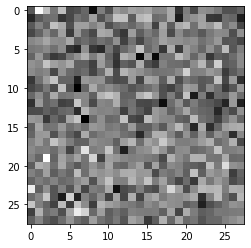

In [93]:
# for i in range(10):
#     imshow(test.forward(x[i,:]))
imshow(test.forward(x))

As it can be seen above, without training the model essentialy generates noise. 

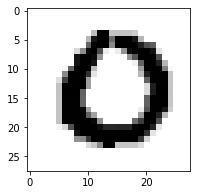

In [123]:
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)



# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 512

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

dataiter = iter(train_loader)
images, labels = dataiter.next()

images_np = images.numpy()


# get one image from the batch
img = np.squeeze(images_np[np.random.randint(len(images))])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray_r')
plt.show()

### A first benchmark with a simple $\ell_2$ loss

In [95]:
# test if the network is training as expected on a dummy example
# should generate an "average" image

if cuda:  
  test = MultilayerPerceptron(2, 500, 784).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(test.parameters(), lr = 0.02) # same optimizer as in the paper

z_size = 2
test.train()
epochs = 10 # not necessary to put many epochs
samples_evolution = []
losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        batch_size = real_images.size(0)
        #real_images = real_images*2 - 1 # rescale the images
        real_images = real_images.view(-1, 28*28).cuda()
                
        optimizer.zero_grad()
        # Forward pass
        z = torch.rand((batch_size,z_size), requires_grad=True).cuda()
        y_pred = test(z).cuda()
            
        # Compute Loss 
        loss = criterion(y_pred, real_images) # this loss will be replaced by the sinkhorn loss
   
        
        # Backward pass
        loss.backward()
        optimizer.step()
    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    losses.append(loss.item())
    if epoch%10==0:    
        # add an image to the list to see the improvements
        print('Generating an image after %s epochs' %epoch)
        x = torch.rand(2, requires_grad=True).cuda()
        samples_evolution.append(test(x))

Epoch 0: train loss: 0.06508
Generating an image after 0 epochs
Epoch 1: train loss: 0.06427
Epoch 2: train loss: 0.06340
Epoch 3: train loss: 0.06338
Epoch 4: train loss: 0.06338
Epoch 5: train loss: 0.06337
Epoch 6: train loss: 0.06338
Epoch 7: train loss: 0.06338
Epoch 8: train loss: 0.06338
Epoch 9: train loss: 0.06338


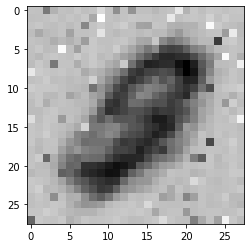

In [96]:
imshow(samples_evolution[-1]) # Just plot the last image

As expected, when evaluating against a batch of images, we end up generating "average" images.

In [0]:
imshow(samples_evolution[-1])
# plt.savefig("img/training_L2_loss.png")

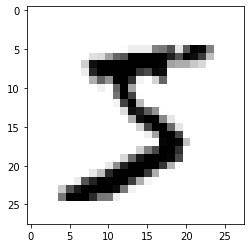

In [0]:
# for i in range(10):
#     imshow(img_test[i])
imshow(img_test)

### Implementation of OT-GAN (v1)
#### Definition of the necessary functions

In [0]:
def cost_matrix(mu,nu):
    """
    computes the cost matrix between two distributions of size n
    with d points each
    
    norm : l2 norm
    
    returns a cost matrix of size n*n
    """
    
    # sizes and reshape the tensors
    bs, n = mu.size()
    bs2, m = nu.size()
    
    x_reshape = mu.view(n, bs)
    y_reshape = nu.view(m, bs2)

    if cuda:
    
      # clone the tensors
      x_i = torch.clone(x_reshape[:, None]).requires_grad_(True).cuda()
      y_j = torch.clone(y_reshape[None,:]).requires_grad_(True).cuda()

    else:
      # clone the tensors
      x_i = torch.clone(x_reshape[:, None]).requires_grad_(True)
      y_j = torch.clone(y_reshape[None,:]).requires_grad_(True)

    
    if cuda:
      C = ((x_i - y_j) ** 2).sum(-1).cuda()
      return C/C.max()
    else:
      C = ((x_i - y_j) ** 2).sum(-1)
      return C/C.max()

def sinkhorn_wasserstein(x, y, C, epsilon=1., max_iters = 50):
    """
    uses sinkhorn algorithm to approximate the optimal
    transport plan between two input measures x and y.
    
    computes the cost matrix (l2 norm) and alternate
    projections to compute the 
    """
    
    # compute the empirical distributions over the batches
    x_mean = x.view(784, -1).mean(1, keepdim=False).cuda()
    x_mean = x_mean / x_mean.max()
    y_mean = y.view(784, -1).mean(1, keepdim=False).cuda()
    y_mean = y_mean / y_mean.max()
           
    # Compute the kernel matrix K
    K = torch.exp(-C/epsilon).cuda()
    
    # Alternate projections
    v = torch.ones(y_mean.size()).cuda()
    
    if cuda:
      for _ in range(max_iters):
          u = x_mean / torch.mv(K,v).cuda()
          u = u / u.max()
          v = y_mean / torch.mv(K.t(),u).cuda()
          v = v / v.max()
    else:
        for _ in range(max_iters):
          u = x_mean / torch.mv(K,v) 
          v = y_mean / torch.mv(K.t(),u) 

        
    diag_u = torch.diag(u)
    diag_v = torch.diag(v)
    u_dot_K = torch.mm(diag_u,K)
    
    # Approximation of the optimal transport plan
    P_L = torch.mm(u_dot_K,diag_v)
    
    # Approximation of the Wasserstein Loss
    W_L = torch.trace(torch.mm(P_L.t(),C))
    
    return W_L


def sinkhorn_loss(x,y, epsilon = 1., max_iters = 50):
    """
    returns the sinkhorn loss
    """
    # cost matrices
    C_xx, C_xy, C_yy = cost_matrix(x,x), cost_matrix(x,y), cost_matrix(y,y)
    
    # wasserstein losses 
    W_xx = sinkhorn_wasserstein(x,x, C_xx, epsilon = epsilon, max_iters = max_iters)
    W_xy = sinkhorn_wasserstein(x,y, C_xy, epsilon = epsilon, max_iters = max_iters)
    W_yy = sinkhorn_wasserstein(y,y, C_yy, epsilon = epsilon, max_iters = max_iters)
    
    
    return 2 * W_xy - W_xx - W_yy

In [0]:
cuda = torch.cuda.is_available()
                                 
if cuda:  
  model = MultilayerPerceptron(2, 500, 784).cuda()


#### First try - implementation with sinkhorn loss

In [0]:
# training with custom loss

optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.02) # same optimizer as in the paper

z_size = 2
batch_size = 128
model.train()
epochs = 50
samples_evolution_sk = []
losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        #with torch.no_grad():
        batch_size = real_images.size(0)
        #real_images = real_images*2 - 1 # rescale the images
        real_images = real_images.view(-1, 28*28)
        if cuda : 
          real_images.cuda()
                
        optimizer.zero_grad()
        
        # Forward pass
        z = torch.rand((batch_size,z_size), requires_grad=True)
        if cuda :
          z = z.cuda()

        y_pred = model(z)
            
        # Compute Loss 
        loss = sinkhorn_loss(y_pred, real_images, epsilon = 1) 

        # Backward pass
        loss.backward()
        optimizer.step()
    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    losses.append(loss.item())
    if epoch%10==0:    
        # add an image to the list to see the improvements
        print('Generating an image after %s epochs' %epoch)
        x = torch.rand(2, requires_grad=True).cuda()
        samples_evolution_sk.append(model(x))

Epoch 0: train loss: nan
Generating an image after 0 epochs


KeyboardInterrupt: ignored

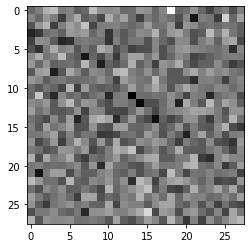

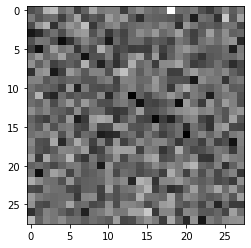

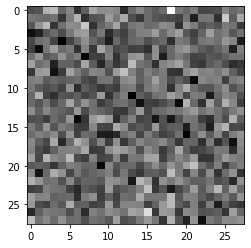

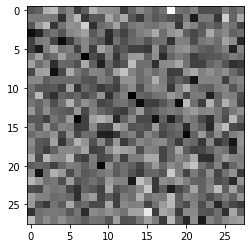

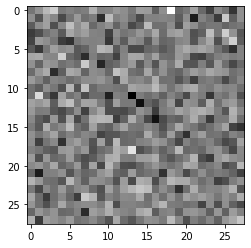

In [0]:
for img in samples_evolution_sk:
    imshow(img)

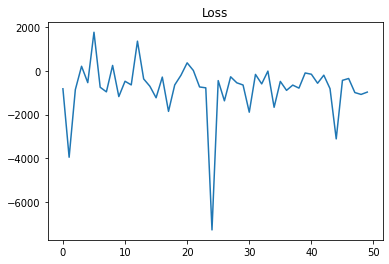

In [0]:
plt.plot(np.array(losses))
plt.title('Loss')
plt.savefig('loss_first_trial.png')

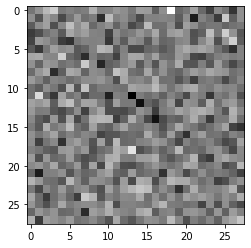

<Figure size 432x288 with 0 Axes>

In [0]:
imshow(samples_evolution_sk[-1])
plt.savefig('images_first_trial_e50.png')

### Sinkhorn, second try

As we can see, the sinkhorn GAN is not working as expected. In this section we try to understand why and implement the necessary modifications. 

Definition of the three ingredients needed : a cost matrix, the computation of the transport cost w and the compuation of the sinkhorn loss

In [0]:
def cost_matrix(x,y, normalize = True):
  """
  computes the cost matrix between two tensors x and y

  x of size batch * size
  y of size batch * size

  normalize : a boolean to indicate whether the matrix
  must be normalized

  returns the l2 pairwise distance

  version 09.12 checked: works almost properly.
  """

  # reshape the tensors from (bs, n) to (n, bs) 
  # for the computations 
  bs, n = x.size()
  bs2, m = y.size()
    
  x = x.view(n, bs).cuda()
  y = y.view(m, bs2).cuda()

  if cuda :
    C = ((x[:,None] - y) ** 2).sum(-1).cuda()
  else: 
    C = ((x[:,None] - y) ** 2).sum(-1)

  if normalize :
  # take the max between 1 and 0 to avoid nan if distance is 0
    C_max = max(1,C.max())
    return C/C_max
  else:
    return C 

In [0]:
def sinkhorn_iterates(mu, nu, C, epsilon = 0.1, max_iters = 50):
  """
  computes the sinkhorn loss as in algorithm 2 from Genevay et al (2017)

  mu, nu : the distributions between which the transport plan is computed
  C : the cost matrix between mu and nu

  epsilon : regularization factor
  max_iters : number of sinkhorn iterates

  returns the cost w

  ambiguité : est-ce qu'on moyennise ou pas quand on prend la distribution ?
  comportement de la loss checké : vaut 0 pour deux vecteurs dont le cout est 0
  version normalement à jour et fonctionnelle. 
  suit le papier (sinkhorn iterates pas comme le td !)
  """

  # compute the empirical distributions over the batches
  mu = mu.view(28*28, -1).mean(1, keepdim=False).cuda()
  nu = nu.view(28*28, -1).mean(1, keepdim=False).cuda()

  # Compute the kernel matrix
  K = torch.exp(-C/epsilon).cuda()

  # sinkhorn iterates (as in the paper)
  b = torch.ones(nu.size(0)).cuda()

  for _ in range(max_iters):
    a = torch.ones(nu.size(0)).cuda() / torch.mv(K,b).cuda()
    b = torch.ones(mu.size(0)).cuda() / torch.mv(K.t(), a).cuda()

  # return the optimal transport plan
  # formula : from the lectures
  P_eps = torch.mm(torch.mm(torch.diag(a), K), torch.diag(b)).cuda()
  
  return torch.trace(torch.mm(P_eps.t(),C)).cuda()

In [0]:
def sinkhorn_loss(mu, nu, epsilon = 0.01, max_iters = 50, normalize = True):
  """
  updated wrapper, returns the sinkhorn loss between two measures
  mu and nu

  returns

  E_L = 2w(mu,nu) - w(mu,mu) - w(nu,nu) (as in theorem 1 of the paper)

  sanity check performed : indeed returns 0 for two identical tensors. 
  version correcte à prendre
  """

  # compute the cost matrices
  C_xy = cost_matrix(mu, nu, normalize = normalize)
  C_xx = cost_matrix(mu, mu, normalize = normalize)
  C_yy = cost_matrix(nu, nu, normalize = normalize)

  # computes the losses
  W_xy = sinkhorn_iterates(mu,nu, C_xy, epsilon = epsilon, max_iters = max_iters)
  W_x = sinkhorn_iterates(mu,mu, C_xx, epsilon = epsilon, max_iters = max_iters)
  W_y = sinkhorn_iterates(nu,nu, C_yy, epsilon = epsilon, max_iters = max_iters)

  return 2 * W_xy - W_x - W_y


### Sinkhorn, v3

In [0]:
def cost_matrix(x, y, normalize = True):
  """
  returns the matric of |x_i-y_j|^2

  x, y : batch tensors

  normalize : true to normalize weights
  """

  """ cosine similarity 
  def sim_matrix(a, b, eps=1e-8):
    
    added eps for numerical stability
    
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt
  """
  
  # reshape the tensors from (bs, n) to (n, bs) 
  # for the computations 
  bs, n = x.size()
  bs2, m = y.size()
    
  x = x.view(n, bs).cuda()
  y = y.view(m, bs2).cuda()


  # compute the cost
  x_col = x.unsqueeze(-2)
  y_lin = y.unsqueeze(-3)
  C = torch.sum((torch.abs(x_col - y_lin)) ** 2, -1)

  if normalize:
    return C/max(1,C.max())

  else : 
    return C

In [0]:
def cosine_matrix(x,y,eps = 1e-5):
  """
  computes the cosine similarity matrix between x and y

  arguemnts:
  x, y : batches
  eps : added to avoid nans

  returns a matrix 

  """
  # reshape the tensors from (bs, n) to (n, bs) 
  # for the computations 
  bs, n = x.size()
  bs2, m = y.size()
    
  x = x.view(n, bs).cuda()
  y = y.view(m, bs2).cuda()

  return 1 - torch.mm(x,y.t())/ max(torch.norm(x, p=2)*torch.norm(y, p=2), eps)


In [113]:
cosine_matrix(y_pred,y_pred)

tensor([[0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
        [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
        [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
        ...,
        [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
        [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
        [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987]],
       device='cuda:0', grad_fn=<RsubBackward1>)

In [0]:
untrained = MultilayerPerceptron(2,500,28*28).cuda()

In [0]:
# check on a dummy example
z = torch.rand((96, 2)).cuda()
y_rand = untrained(z)

C = cost_matrix(y_rand, real_images)
C

In [0]:
def sinkhorn_distance(C, epsilon = 0.01, max_iters = 100):
  """
  Compute the sinkhorn distance between batch vectors x and y

  input : cost matrix C

  outputs : a scalar corresponding to the cost
  """

  # dimensions of the data (should be the same in our case)
  n, m = C.size()

  # Kernel matrix
  K = torch.exp(-C/epsilon).cuda()

  # Sinkhorn iterates
  a = torch.ones(m).cuda()
  b = torch.ones(n).cuda()

  #actual loop 
  v = torch.ones(n).cuda()
  for _ in range(max_iters):
    u = a / torch.mv(K,v).cuda()
    v = b / torch.mv(K.t(), u).cuda()

  M = torch.matmul(torch.matmul(torch.diag(u),K),torch.diag(v)).cuda()
  return torch.sum(M*C)


In [115]:
# sanity check, again
sinkhorn_distance(C)

tensor(0.2146, device='cuda:0', grad_fn=<SumBackward0>)

In [0]:
def sinkhorn_loss(x, y, epsilon = 0.01, max_iters = 50 ,normalize = True):
  """
  Wrapper of the two functions, returns the sinkorn loss between
  batches x and y
  """

  # cost matrices
  #C_xy = cost_matrix(x, y, normalize = normalize)
  #C_xx = cost_matrix(x, x, normalize = normalize)
  #C_yy = cost_matrix(y, y, normalize = normalize)

  C_xy = cosine_cost(x, y)
  C_xx = cosine_cost(x, x)
  C_yy = cosine_cost(y, y)

  # losses

  W_xy = sinkhorn_distance(C_xy, epsilon = epsilon, max_iters = max_iters)
  W_xx = sinkhorn_distance(C_xx, epsilon = epsilon, max_iters = max_iters)
  W_yy = sinkhorn_distance(C_yy, epsilon = epsilon, max_iters = max_iters)

  return 2 * W_xy - W_xx - W_yy

In [117]:
# checks that the loss is non negative and decreasing
print(sinkhorn_loss(y_rand, real_images), sinkhorn_loss(y_rand,y_rand))


RuntimeError: ignored

In [124]:
# train the model with the custom loss

cuda = torch.cuda.is_available()
                                 
if cuda:  
  model2 = MultilayerPerceptron(2, 500, 784).cuda()

# training with custom loss
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.02) # same optimizer as in the paper
                                                             # for the mnist experiment
z_size = 2
batch_size = 512
model2.train()
epochs = 10
samples_evolution_sk = []
losses = []
for epoch in range(epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        #with torch.no_grad():
        batch_size = real_images.size(0)
        #real_images = real_images*2 - 1 # rescale the images
        real_images = real_images.view(-1, 28*28)
        if cuda : 
          real_images.cuda()
                
        optimizer.zero_grad()
        
        # Forward pass
        z = torch.rand((batch_size,z_size), requires_grad=True)
        if cuda :
          z = z.cuda()

        y_pred = model2(z)
            
        # Compute Loss 
        loss = sinkhorn_loss(y_pred, real_images, epsilon = 1)

        # Backward pass
        loss.backward()
        optimizer.step()
    print('Epoch %s: train loss: %0.5f' %(epoch, loss.item()))
    losses.append(loss.item())
    if epoch%10==0:    
        # add an image to the list to see the improvements (if any)
        print('Generating an image after %s epochs' %epoch)
        x = torch.rand(2, requires_grad=False).cuda()
        samples_evolution_sk.append(model2(x))

Epoch 0: train loss: -1.87638
Generating an image after 0 epochs
Epoch 1: train loss: -1.87639
Epoch 2: train loss: -1.87639
Epoch 3: train loss: -1.87639
Epoch 4: train loss: -1.87639
Epoch 5: train loss: -1.87639
Epoch 6: train loss: -1.87639
Epoch 7: train loss: -1.87639
Epoch 8: train loss: -1.87639
Epoch 9: train loss: -1.87639


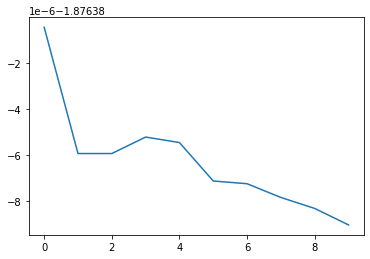

In [125]:
# plot some samples and the loss
plt.plot(losses)
plt.savefig('losses_v4.png')

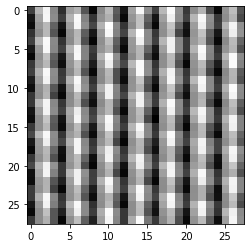

In [126]:
for img in samples_evolution_sk:
  imshow(img)

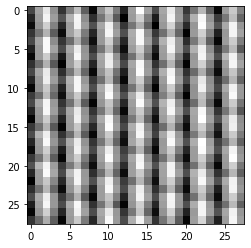

In [129]:
x = torch.rand(2).cuda()
imshow(model2(x))
# not really a mnist digit, but not noise either

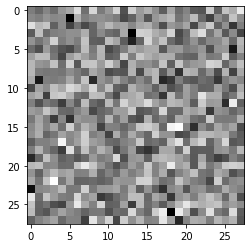

<Figure size 432x288 with 0 Axes>

In [0]:
# save the last image 
imshow(samples_evolution_sk[-1])
plt.savefig('sample_v2.png')